In [4]:
using Revise
includet("utils/file_reader.jl")
includet("utils/some_data.jl")
includet("utils/utils_graph.jl")
includet("resolution/compact/compact_formulation.jl")
includet("resolution/path/path_generation.jl")
using Revise, JuMP, CPLEX



In [43]:
instance = get_instance_from_folder("instances/realistic/2806/easyone/")


InstanceVNE(Any[Meta graph based on a SimpleDiGraph{Int64} with vertex labels of type Int64, vertex metadata of type Dict, edge metadata of type Dict, graph metadata given by Dict(:type => "virtual", :name => "wheel_3"), and default weight 1.0], Meta graph based on a SimpleDiGraph{Int64} with vertex labels of type Int64, vertex metadata of type Dict, edge metadata of type Dict, graph metadata given by Dict(:type => "substrate", :name => "zoo_Xeex"), and default weight 1.0)

In [44]:
# déjà faire le two-stage et voir que c'est super naze 
print("Constructing compact model...")

#### Model
model_placement = Model(CPLEX.Optimizer)
set_attribute(model_placement, "CPX_PARAM_EPINT", 1e-8)

### Variables
x_variables = @variable(model_placement, x[v_network in instance.v_networks, vertices(v_network), vertices(instance.s_network)], binary=true);

### Objective
placement_cost = @expression(model_placement, sum( instance.s_network[s_node][:cost] * v_network[v_node][:dem] * x[v_network, v_node, s_node] 
    for v_network in instance.v_networks for v_node in vertices(v_network) for s_node in vertices(instance.s_network) ))
@objective(model_placement, Min, placement_cost);

### Constraints

# one substrate node per virtual node
for v_network in instance.v_networks
    for v_node in vertices(v_network)
        @constraint(model_placement, sum(x[v_network, v_node, s_node] for s_node in vertices(instance.s_network)) == 1)
    end
end

# node capacity
for s_node in vertices(instance.s_network)
    @constraint(model_placement, 
        sum( v_network[v_node][:dem] * x[v_network, v_node, s_node] 
            for v_network in instance.v_networks for v_node in vertices(v_network) ) 
        <= 
        instance.s_network[s_node][:cap] )
end

# Solving
set_time_limit_sec(model_placement, 30.)
optimize!(model_placement)

# Get the solution
x_values = value.(x_variables);
node_placements = []
for v_network in instance.v_networks
    node_placement = []
    for v_node in vertices(v_network)
        current_placement = []
        for s_node in vertices(instance.s_network)
            if x_values[v_network, v_node, s_node] > 0.99
                push!(current_placement, 1)
            else
                push!(current_placement, 0)
            end
        end
        push!(node_placement, current_placement)
    end
    push!(node_placements, node_placement)
end

Constructing compact model...Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               30
CPXPARAM_MIP_Tolerances_Integrality              1e-08
Found incumbent of value 4.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 28 rows, 96 columns, and 192 nonzeros.
Reduced MIP has 96 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.12 ticks)
Probing time = 0.00 sec. (0.12 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 28 rows, 96 columns, and 192 nonzeros.
Reduced MIP has 96 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.19 ticks)
Probing time = 0.00 sec. (0.12 ticks)
Clique table members: 28.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.05 ticks)

        Nodes                                         C

In [47]:
for i_v_network in 1:length(instance.v_networks)
    println("Virtual network n" * string(i_v_network))
    for v_node in vertices(instance.v_networks[i_v_network])
        for s_node in vertices(instance.s_network)
            if node_placements[i_v_network][v_node][s_node] > 0.99
                println(string(v_node) * " => " * string(s_node))
            end
        end
    end
end

Virtual network n1
1 => 1
2 => 2
3 => 3
4 => 4


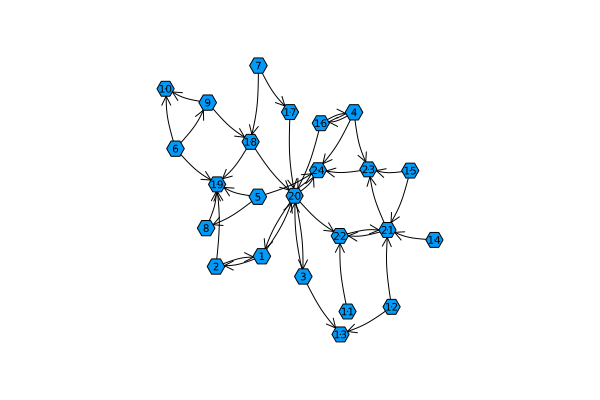

In [49]:
includet("utils/visu.jl")
visu_graph(instance.s_network)

In [46]:
print("Constructing compact model...")

#### Model
model_routing = Model(CPLEX.Optimizer)
set_attribute(model_routing, "CPX_PARAM_EPINT", 1e-8)

### Variables
y_variables = @variable(model_routing, y[v_network in instance.v_networks, edges(v_network), edges(instance.s_network)], binary=true);

### Objective
routing_cost = @expression(model_routing, sum( instance.s_network[src(s_edge), dst(s_edge)][:cost] * v_network[src(v_edge), dst(v_edge)][:dem] * y[v_network, v_edge, s_edge] 
    for v_network in instance.v_networks for v_edge in edges(v_network) for s_edge in edges(instance.s_network) ))
@objective(model_routing, Min, routing_cost);


### Constraints
# edge capacity
for s_edge in edges(instance.s_network)
    @constraint(model_routing, 
        sum( v_network[src(v_edge), dst(v_edge)][:dem] * y[v_network, v_edge, s_edge] 
            for v_network in instance.v_networks for v_edge in edges(v_network)) 
        <= 
        instance.s_network[src(s_edge), dst(s_edge)][:cap] )
end

# Flow conservation
for s_node in vertices(instance.s_network)
    for i_v_network in 1:length(instance.v_networks)
        v_network = instance.v_networks[i_v_network]
        for v_edge in edges(v_network)
            @constraint(model_routing, 
            node_placements[i_v_network][src(v_edge)][s_node] - node_placements[i_v_network][dst(v_edge)][s_node] 
                ==
                sum(y[v_network, v_edge, s_edge] for s_edge in get_out_edges(instance.s_network, s_node)) - 
                    sum(y[v_network, v_edge, s_edge] for s_edge in get_in_edges(instance.s_network, s_node))
            )
        end
    end
end

set_time_limit_sec(model_routing, 30.)
optimize!(model_routing)


Constructing compact model...Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_TimeLimit                               30
CPXPARAM_MIP_Tolerances_Integrality              1e-08
Row 'c94' infeasible, all entries at implied bounds.
Presolve time = 0.00 sec. (0.05 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.07 ticks)
Parallel b&c, 8 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.07 ticks)
